# Load data

In [1]:
import xarray as xr 
from typing import Tuple


ds = xr.open_dataset('soil-water-forecasting/modeling-pipeline/data/02_intermediate/preprocessed_data.nc', chunks="auto")

In [2]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:     (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude    (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude   (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
Data variables: (12/24)
    swvl1       (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...          ...
    lsm         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    si10        (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    e           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

# Feature imputation

In [3]:
# Update swvl1: Set to 1 wherever lsm indicates water (lsm == 1)
ds['swvl1'] = ds['swvl1'].where(ds['lsm'] != 0, other=1)

# Units Conversion

In [4]:
# Save the original attributes
original_attrs = ds['tp'].attrs

# Perform the conversion
ds['tp'] = ds['tp'] * 1000

# Restore the original attributes and update the units
ds['tp'].attrs = original_attrs
ds['tp'].attrs['units'] = 'mm'  # Update the units attribute to 'mm'

In [5]:
# Save the original attributes
original_attrs = ds['pev'].attrs

# Perform the conversion
ds['pev'] = ds['pev'] * 1000

# Restore the original attributes and update the units
ds['pev'].attrs = original_attrs
ds['pev'].attrs['units'] = 'mm'  # Update the units attribute to 'mm'

# Calculate Percent of Normal Precipitation

In [6]:
def calculate_percent_of_normal_precipitation(
    ds: xr.Dataset, 
    variable: str, 
    date_range: Tuple[str, str]
) -> xr.Dataset:
    """
    Calculate Percent of Normal Precipitation (PNP) for a specific variable.

    Args:
        ds (xr.Dataset): Input dataset containing the variable.
        variable (str): Variable name for which PNP is to be calculated.
        date_range (Tuple[str, str]): Climatology period as (start_date, end_date).

    Returns:
        xr.Dataset: Dataset with PNP added as a new variable.
    """
    # Ensure the variable exists
    if variable not in ds.variables:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")
    
    # Step 1: Filter dataset for the climatology period
    start_date, end_date = date_range
    ds_clim_period = ds.sel(valid_time=slice(start_date, end_date))
    
    # Step 2: Extract the variable and calculate monthly climatology mean
    data_clim_period = ds_clim_period[variable]
    climatology_mean = data_clim_period.groupby('valid_time.month').mean('valid_time')
    
    # Replace zeros and NaNs in climatology_mean with a small number
    climatology_mean = climatology_mean.where(climatology_mean > 0, other=1e-10).fillna(1e-10)

    # Step 3: Calculate PNP for all valid_time in the original dataset
    data_full = ds[variable]
    percent_of_normal_precipitation = xr.apply_ufunc(
        lambda x, m: (x / m) * 100,
        data_full.groupby('valid_time.month'),
        climatology_mean,
        dask="allowed"
    )

    # Replace NaNs in the result with meaningful values or keep them masked
    percent_of_normal_precipitation = percent_of_normal_precipitation.fillna(-9999)  # or another placeholder value

    # Step 4: Add PNP to the original dataset
    ds_pnp = ds.copy()
    ds_pnp[f"{variable}_pnp"] = percent_of_normal_precipitation

    return ds_pnp


In [7]:
# Example Usage
date_range = ("1979-01-01", "2019-12-31")

# Assuming `ds` is your dataset
ds = calculate_percent_of_normal_precipitation(ds, variable='tp', date_range=date_range)

In [8]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:     (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude    (latitude) int64 1kB -90 -89 -88 -87 -86 -85 ... 85 86 87 88 89
  * longitude   (longitude) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    month       (valid_time) int64 4kB 1 2 3 4 5 6 7 8 9 ... 3 4 5 6 7 8 9 10 11
Data variables: (12/25)
    swvl1       (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...          ...
    si10        (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    e           (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_pnp      (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [9]:
ds["tp_std_anomaly_binary"] = (ds["tp_pnp"] > 50).astype(int)

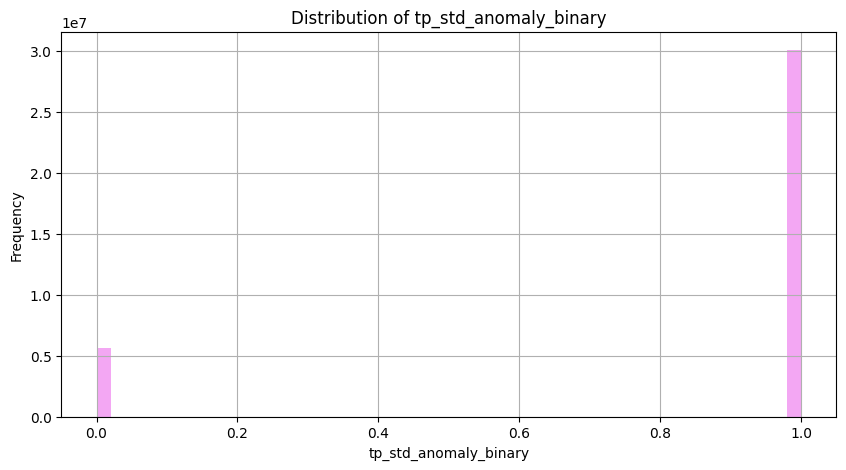

In [10]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional

def plot_variable_distributions(ds: xr.Dataset, variables: Optional[List[str]] = None) -> None:
    """
    Plot the distribution of specified variables in the xarray Dataset.
    If no variables are specified, plot the distributions of all variables.

    Args:
        ds (xr.Dataset): The xarray dataset containing variables to visualize.
        variables (List[str], optional): List of variable names to plot.
                                         If None, plots all variables.
    """
    # Determine variables to plot
    variables_to_plot = variables if variables else list(ds.data_vars)
    
    for var in variables_to_plot:
        if var not in ds:
            print(f"Variable '{var}' not found in the dataset. Skipping.")
            continue
        
        data = ds[var].values.flatten()  # Flatten the data for distribution plot
        
        # Remove NaN values to avoid plotting issues
        data = data[~np.isnan(data)]
        
        plt.figure(figsize=(10, 5))
        plt.hist(data, bins=50, alpha=0.7, color='violet')
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()




# To plot specific variables
plot_variable_distributions(ds, variables=['tp_std_anomaly_binary'])

# Adding Temporal Features

In [11]:
# Extract the season from the time coordinate
ds['season'] = ds['valid_time'].dt.season

In [12]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:                (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time             (valid_time) datetime64[ns] 4kB 1979-01-01 ... 202...
  * latitude               (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude              (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    month                  (valid_time) int64 4kB 1 2 3 4 5 6 ... 6 7 8 9 10 11
Data variables: (12/27)
    swvl1                  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...                     ...
    ro                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_pnp                 (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    tp_std_anomaly_binary  (valid_time, latitude, longitude) int64 286MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    season                 (valid_time) <U3 7kB 'DJF' 'DJF' ... 'SON' 'SON'
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [13]:
# Define a dictionary to map season strings to numerical values
season_mapping = {'DJF': 1, 'MAM': 2, 'JJA': 3, 'SON': 4}

# Convert the DataArray to a pandas Series, map the season names, and convert back to a DataArray
ds['season'] = ds['season'].to_series().map(season_mapping).to_xarray()

In [14]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:                (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time             (valid_time) datetime64[ns] 4kB 1979-01-01 ... 202...
  * latitude               (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude              (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    month                  (valid_time) int64 4kB 1 2 3 4 5 6 ... 6 7 8 9 10 11
Data variables: (12/27)
    swvl1                  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...                     ...
    ro                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_pnp                 (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    tp_std_anomaly_binary  (valid_time, latitude, longitude) int64 286MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    season                 (valid_time) int64 4kB 1 1 2 2 2 3 3 ... 3 3 3 4 4 4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [15]:
# Broadcast 'season' to match dimensions (date, latitude, longitude)
season_broadcasted = ds['season'].expand_dims({'latitude': ds.latitude, 'longitude': ds.longitude})

# Add this expanded 'season' variable back to the dataset
ds['season'] = season_broadcasted

# Transpose 'season' to match the desired dimensions (date, latitude, longitude)
ds['season'] = ds['season'].transpose('valid_time', 'latitude', 'longitude')

In [16]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:                (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time             (valid_time) datetime64[ns] 4kB 1979-01-01 ... 202...
  * latitude               (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude              (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    month                  (valid_time) int64 4kB 1 2 3 4 5 6 ... 6 7 8 9 10 11
Data variables: (12/27)
    swvl1                  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...                     ...
    ro                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_pnp                 (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    tp_std_anomaly_binary  (valid_time, latitude, longitude) int64 286MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    season                 (valid_time, latitude, longitude) int64 286MB 1 ... 4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [17]:
# Convert season to int8
ds['season'] = ds['season'].astype('int32')

In [18]:
ds

<xarray.Dataset> Size: 4GB
Dimensions:                (valid_time: 551, latitude: 180, longitude: 360)
Coordinates:
  * valid_time             (valid_time) datetime64[ns] 4kB 1979-01-01 ... 202...
  * latitude               (latitude) int64 1kB -90 -89 -88 -87 ... 86 87 88 89
  * longitude              (longitude) int64 3kB 0 1 2 3 4 ... 356 357 358 359
    month                  (valid_time) int64 4kB 1 2 3 4 5 6 ... 6 7 8 9 10 11
Data variables: (12/27)
    swvl1                  (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cl                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    cvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tvh                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    asn                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    sst                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    ...                     ...
    ro                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp                     (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    pev                    (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(539, 176, 352), meta=np.ndarray>
    tp_pnp                 (valid_time, latitude, longitude) float32 143MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    tp_std_anomaly_binary  (valid_time, latitude, longitude) int64 286MB dask.array<chunksize=(45, 176, 352), meta=np.ndarray>
    season                 (valid_time, latitude, longitude) int32 143MB 1 ... 4
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

tp_minus_E_cumulative total precipitation minus evaportaion 

calaculate specific humidity  
 

Soil Moisture Dynamics

Evapotranspiration Balance: Calculate a moisture balance feature as tp - e (precipitation minus evaporation). This balance can serve as an indicator of moisture availability and stress, especially over rolling windows.

Wind Impact: Combine u10 and v10 (wind components) to create a wind speed variable to assess the drying effect of wind on soil moisture.

Determine Wind Direction: Calculate the wind direction using: Wind speed and direction influence evapotranspiration rates, affecting soil moisture levels.

Temperature Anomalies: Identify deviations from long-term average temperatures to capture unusual thermal conditions impacting soil moisture.

In [19]:
# import xarray as xr

# # Check for missing values in each variable without compute
# missing_values = {var: ds[var].isnull().any().values for var in ds.data_vars}

# # Display the results
# for var, has_missing in missing_values.items():
#     print(f"Variable '{var}': {'Has missing values' if has_missing else 'No missing values'}")

In [20]:
ds.to_netcdf('soil-water-forecasting/modeling-pipeline/data/04_feature/features.nc')